# Differential drive robot (i.e., "segbot") in artificial gravity

Import modules and configure the notebook.

In [12]:
# This module is part of the python standard library
import time

# These modules are part of other existing libraries
import numpy as np
import matplotlib.pyplot as plt
import ipywidgets as widgets
from IPython.display import display
import asyncio

# This is my own script (it is an interface to the pybullet simulator)
import ae353_segbot

In [13]:
import sympy as sym
# Dimensions of chassis
dx = 0.4
dy = 0.6
dz = 0.8

# Distance between axle and COM of chassis
h = 0.3

# Half-distance between wheels
a = 0.7 / 2

# Mass of chassis
mb = 12.

# MOI of chassis
Jbx = (mb / 12) * (dy**2 + dz**2)
Jby = (mb / 12) * (dx**2 + dz**2)
Jbz = (mb / 12) * (dx**2 + dy**2)

# Radius of each wheel
r = 0.325

# Width of each wheel
hw = 0.075

# Mass of each wheel
mw = 1.2

# MOI of each wheel
Jw = (mw / 2) * r**2
Jwt = (mw / 12) * (3 * r**2 + hw**2)

# Total mass
m = mb + 2 * mw

# Total MOI
Jx = Jbx + 2 * Jwt
Jy = Jby
Jz = Jbz + 2 * Jwt

# Station parameters
station_velocity = -0.5 # <-- FIXME (change the velocity to change gravity)
station_radius = 20.    # <-- radius in meters of inside surface of station

# Acceleration of artifical gravity
g = station_velocity**2 * station_radius

# Dimensions
h = sym.nsimplify(h)
a = sym.nsimplify(a)
r = sym.nsimplify(r)

# Masses
mb = sym.nsimplify(mb)
mw = sym.nsimplify(mw)
m = sym.nsimplify(m)

# MOIs
Jx = sym.nsimplify(Jx)
Jy = sym.nsimplify(Jy)
Jz = sym.nsimplify(Jz)
Jw = sym.nsimplify(Jw)
Jwt = sym.nsimplify(Jwt)

# Gravity
g = sym.nsimplify(g)

(e_l,
 e_h,
 v,
 w,
 theta,
 thetadot,
 tau_R,
 tau_L) = sym.symbols('e_l, e_h, v, w, theta, thetadot, tau_R, tau_L', real=True)

M = sym.Matrix([[m + 2 * Jw / r**2, 0, mb * h * sym.cos(theta)],
                [0, (Jx + mb * h**2) * sym.sin(theta)**2 + Jz * sym.cos(theta)**2 + (2 * Jw * a**2 / r**2) + 2 * mw * a**2, 0],
                [mb * h * sym.cos(theta), 0, Jy * mb * h**2]])
N = sym.Matrix([[mb * h * (w**2 + thetadot**2) * sym.sin(theta)],
                [-2 * (Jx - Jz + m * h**2) * sym.cos(theta) * sym.sin(theta) * w * thetadot - mb * h * sym.sin(theta) * v * w],
                [(Jx - Jz + mb * h**2) * sym.cos(theta) * sym.sin(theta) * w**2 + mb * g * h * sym.sin(theta)]])
R = sym.Matrix([[1 / r, 1 / r],
                [-a / r, a / r],
                [-1, -1]])
f = sym.simplify(M.inv() * (N + R * sym.Matrix([[tau_L], [tau_R]])))

omega_p = sym.symbols('omega_p')
f = f.subs(thetadot, omega_p)
equations_M = sym.Matrix([[v * sym.sin(e_h)],
                [w],
                [omega_p],
                [f]])

we, omega_pe, e_he, tau_Re, tau_Le, theta_e, ve = 0., 0., 0., 0., 0., 0., 2.5


x = sym.Matrix([e_l, e_h, v, w, theta, omega_p])
u = sym.Matrix([tau_R, tau_L])

dyn = equations_M.jacobian(x)
controls = equations_M.jacobian(u)

a = sym.lambdify((e_h, e_l, v, theta, w, tau_R, tau_L, omega_p), dyn)
A = np.array(a(e_he, 0, ve, theta_e, we, tau_Re, tau_Le, omega_pe))

b = sym.lambdify((e_h, e_l, v, theta, w, tau_R, tau_L, omega_p), controls)
B = np.array(b(e_he, 0, ve, theta_e, we, tau_Re, tau_Le, omega_pe))

W = np.block([B, A@B, A@A@B, A@A@A@B, A@A@A@A@B, A@A@A@A@A@B])
print(np.linalg.matrix_rank(W))


6


In [163]:
from scipy import linalg
Q = np.diag([100, 100, .001, .001, 1000, 100])
R = np.diag([1, 1])
P = linalg.solve_continuous_are(A, B, Q, R)
K = linalg.inv(R) @  B.T @ P
K

array([[ 9.99919699e+00,  3.96138277e+01,  4.00744446e-04,
         3.03416964e+01,  1.92954974e+01,  1.35470838e-01],
       [ 1.26726521e-01, -6.32779754e+00, -3.16202373e-02,
        -1.20994881e+01, -2.84186447e+01, -1.00074948e+01]])

Create an instance of the `Simulator` class, which is an interface to the [pybullet](http://pybullet.org) simulation engine.

There are several optional arguments:

* `display` (`True` or `False`) is whether or not to show the simulation window;
* `bumpy` (`True` or `False`) is whether or not the station is "bumpy".

In [152]:
simulator = ae353_segbot.Simulator(
    display=False,
    bumpy=False,
)


Create a slider to allow steering the robot.

In [96]:
slider = widgets.FloatSlider(
    value=0.,
    min=-3.,
    max=3.,
    step=0.01,
    description='Centerline:',
    disabled=False,
    continuous_update=True,
    orientation='horizontal',
    readout=True,
    readout_format='.2f',
    layout=widgets.Layout(width='75%', border='solid 2px', margin='10px')
)

Choose a camera view from the following options:
* `camera_sideview()`
* `camera_backview()`
* `camera_wideview()`

In [120]:
simulator.camera_backview()

Define a controller that maps sensor measurements to actuator commands. By default, it chooses to apply zero torque to both the right and left wheels. Modify the `run` function to make the controller behave differently. This function will be called 100 times per second (i.e., at 100 Hz) by the simulator.

In [153]:
class Controller:
    def __init__(self):
        pass
    
    def reset(self):
        pass
    
    def run(
            self,
            t,
            lateral_error,
            heading_error,
            forward_speed,
            turning_rate,
            pitch_angle,
            pitch_rate,
        ):
        
        # FIXME: replace the following lines
        x = np.array([lateral_error, heading_error, forward_speed, turning_rate, pitch_angle, pitch_rate])
        u = -K @ x
        right_wheel_torque = u[0]
        left_wheel_torque = u[1]
        
        return right_wheel_torque, left_wheel_torque

Create an instance of the controller.

In [154]:
controller = Controller()


Reset the simulator with given initial conditions. You may also change the angular velocity of the station if you like, but - beware! - doing so will change the amount of artificial gravity.

In [155]:
simulator.reset(
    initial_speed=1.,
    initial_lateral_error=1.,
    initial_heading_error=0.,
    initial_pitch=0.,
    station_velocity=-0.5,
)

Reset the controller.

In [156]:
controller.reset()

Reset the slider.

In [103]:
slider.value = 0.

Run the simulator with steering. Note that this function runs **asynchronously** to allow user input. You **must** wait until the simulator finishes running before doing anything else in the notebook.

In [104]:
# Show the slider, to allow steering the robot
display(slider)

# Run the simulation asynchronously, to allow using the slider
obj = asyncio.ensure_future(
    simulator.run(
        controller,           # <-- required (an instance of your Controller class)
        max_time=10.0,         # <-- optional (how long you want to run the simulation in seconds)
        data_filename=None,   # <-- optional (save data to this file, e.g., 'my_data.json')
        video_filename=None,  # <-- optional (save video to this file, e.g., 'my_video.mov')
        slider=slider,        # <-- optional (allow steering)
        print_debug=True,     # <-- optional (say when the simulator has finished running)
    )
)

FloatSlider(value=0.0, description='Centerline:', layout=Layout(border_bottom='solid 2px', border_left='solid …

Get results of running the simulator with steering.

In [108]:
if obj.done():
    data = obj.result()
else:
    print('You cannot get results until after the simulator is done running.')

Run the simulator with no steering.

In [157]:
data = await simulator.run(
    controller,           # <-- required (an instance of your Controller class)
    max_time=15.0,         # <-- optional (how long you want to run the simulation in seconds)
    data_filename=None,   # <-- optional (save data to this file, e.g., 'my_data.json')
    video_filename=None,  # <-- optional (save video to this file, e.g., 'my_video.mov')
    slider=None,          # <-- optional (allow no steering)
)

Get, show, and save a snapshot of the simulation after the last time step.

In [ ]:
# Get snapshot as height x width x 4 numpy array of RGBA values
rgba = simulator.snapshot()

# Display snapshot
plt.figure(figsize=(8, 8))
plt.imshow(rgba)

# Save snapshot
plt.imsave('my_snapshot.png', rgba)

Plot the results.

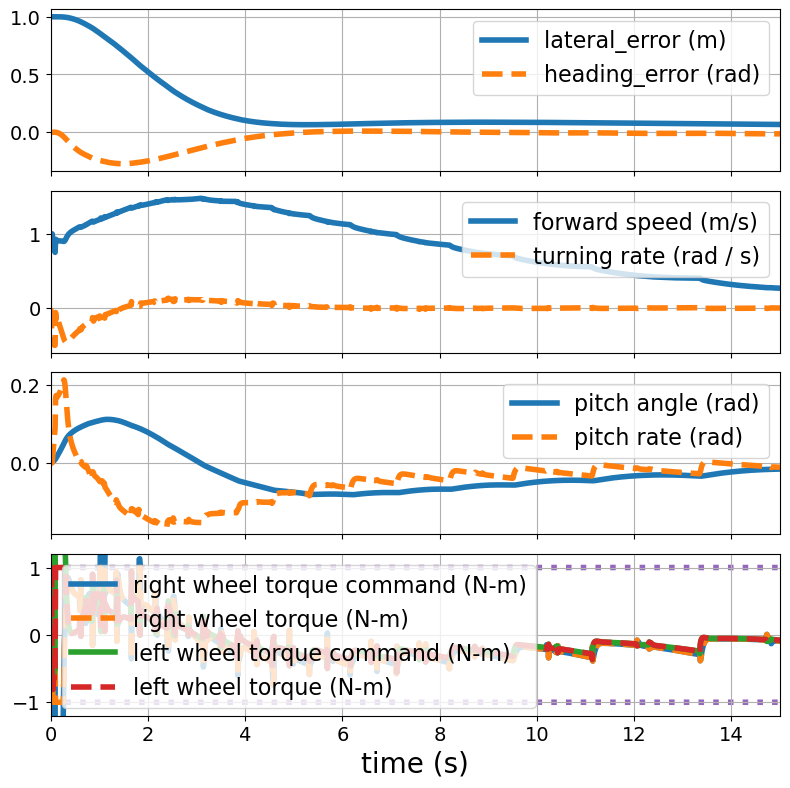

In [158]:
# Create a figure with three subplots, all of which share the same x-axis
fig, (ax_pos, ax_vel, ax_pitch, ax_torque) = plt.subplots(4, 1, figsize=(8, 8), sharex=True)

# Plot lateral and heading error
ax_pos.plot(
    data['t'], data['lateral_error'],
    label='lateral_error (m)', linewidth=4,
)
ax_pos.plot(
    data['t'], data['heading_error'],
    '--', label='heading_error (rad)', linewidth=4,
)
ax_pos.grid()
ax_pos.legend(fontsize=16)
ax_pos.tick_params(labelsize=14)

# Plot forward speed and turning rate
ax_vel.plot(
    data['t'], data['forward_speed'],
    label='forward speed (m/s)', linewidth=4,
)
ax_vel.plot(
    data['t'], data['turning_rate'],
    '--', label='turning rate (rad / s)', linewidth=4,
)
ax_vel.grid()
ax_vel.legend(fontsize=16)
ax_vel.tick_params(labelsize=14)

# Plot pitch angle and pitch rate
ax_pitch.plot(
    data['t'], data['pitch_angle'],
    label='pitch angle (rad)', linewidth=4,
)
ax_pitch.plot(
    data['t'], data['pitch_rate'],
    '--', label='pitch rate (rad)', linewidth=4,
)
ax_pitch.grid()
ax_pitch.legend(fontsize=16)
ax_pitch.tick_params(labelsize=14)

# Plot torques
ax_torque.plot(
    data['t'], data['right_wheel_torque_command'],
    label='right wheel torque command (N-m)', linewidth=4,
)
ax_torque.plot(
    data['t'], data['right_wheel_torque'],
    '--', label='right wheel torque (N-m)', linewidth=4,
)
ax_torque.plot(
    data['t'], data['left_wheel_torque_command'],
    label='left wheel torque command (N-m)', linewidth=4,
)
ax_torque.plot(
    data['t'], data['left_wheel_torque'],
    '--', label='left wheel torque (N-m)', linewidth=4,
)
ax_torque.plot(
    data['t'], -np.ones_like(data['t']) * simulator.tau_max,
    ':', linewidth=4, color='C4', zorder=0,
)
ax_torque.plot(
    data['t'], np.ones_like(data['t']) * simulator.tau_max,
    ':', linewidth=4, color='C4', zorder=0,
)
ax_torque.grid()
ax_torque.legend(fontsize=16)
ax_torque.tick_params(labelsize=14)
ax_torque.set_ylim(-1.2 * simulator.tau_max, 1.2 * simulator.tau_max)

# Set x-axis properties (only need to do this on the last
# subplot since all subplots share the same x-axis)
ax_torque.set_xlabel('time (s)', fontsize=20)
ax_torque.set_xlim([data['t'][0], data['t'][-1]])

# Make the arrangement of subplots look nice
fig.tight_layout()

Save the figure (without transparent background).

In [ ]:
fig.savefig('my_figure.png', facecolor='white', transparent=False)